In [ ]:
# Workaround for training output not visible in JupyterNotebook https://github.com/microsoft/vscode-jupyter/issues/13163
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [ ]:
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

An image dataset of written number samples.

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

Visual representation of each pixel

In [8]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

<Axes: >

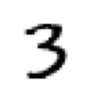

In [9]:
show_image(three_tensors[1])

Stacking all the threes together, and all the sevens together.

In [10]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [ ]:
len(stacked_threes.shape)

In [11]:
stacked_threes.ndim

3

Visual representation of the mean of all threes and sevens.

<Axes: >

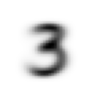

In [12]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

<Axes: >

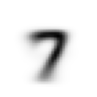

In [13]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

Create tensors from the validation directory.

In [14]:
validation_3_tensor = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
validation_3_tensor = validation_3_tensor.float()/255

validation_7_tensor = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
validation_7_tensor = validation_7_tensor.float()/255

validation_3_tensor.shape, validation_7_tensor.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Try to figure out the distance between a given digit '3' and the mean '3'. 

In [15]:
def mnist_distance(a,b):
    return (a-b).abs().mean((-1,-2))


To do it across the entire validatio nset, same code. Pytorch will expand the 'mean3' to match the dimensions of the validation_3_tensor set and perform substraction. 

In [16]:
validation_3_distance = mnist_distance(validation_3_tensor, mean3)
validation_3_distance, validation_3_distance.shape

(tensor([0.1325, 0.1463, 0.1188,  ..., 0.1571, 0.1329, 0.1611]),
 torch.Size([1010]))

A given image is a 3 if its distance to the ideal 3 is less than the distance to the ideal 7. 

In [18]:
def is_3(given): return mnist_distance(given, mean3) < mnist_distance(given, mean7)


Test the entire set of validation 3s.

In [19]:
is_3(validation_3_tensor)

tensor([True, True, True,  ..., True, True, True])

Get the mean for the entire validation set.

In [20]:
accuracy_3s = is_3(validation_3_tensor).float().mean()
accuracy_7s = (1 - is_3(validation_7_tensor).float()).mean()
accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

MNIST Loss Function
Concatenate the imges into a single tensor and change from a list of rank-3 to list of rank-2 

In [21]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [22]:
# Label each image, use 1 for '3' images and 0 for '7' images
train_y = tensor([1] * len(threes) + [0] * len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [23]:
#A Dataset in PyTorch is required to return a tuple of (x,y) when indexed. Python provides a zip function which, when combined with list, provides a simple way to get this functionality:

dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [28]:
valid_x = torch.cat([validation_3_tensor, validation_7_tensor]).view(-1, 28*28)
valid_y = tensor([1] * len(validation_3_tensor) + [0] * len(validation_7_tensor)).unsqueeze(1)
validation_dataset = list(zip(valid_x, valid_y))

In [29]:
#Now we need an (initially random) weight for every pixel (this is the initialize step in our seven-step process):

def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [32]:
weights = init_params((28*28,1))

In [34]:
bias = init_params(1)

In [43]:
# We can now calculate prediction for one image.
(train_x[0]*weights.T).sum() + bias

tensor([1.4591], grad_fn=<AddBackward0>)

In [44]:
# Using matrix multiplication to predict for the whole batch
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[  1.4591],
        [ -5.3530],
        [-11.0849],
        ...,
        [-14.4085],
        [ -2.6745],
        [ -3.4481]], grad_fn=<AddBackward0>)